In [2]:
import pandas as pd


In [5]:
transactions = pd.read_csv("transactions.csv")
users = pd.read_csv("users.csv")
merchants = pd.read_csv("merchants.csv")

In [6]:
print(transactions.isnull().sum())
print(users.isnull().sum())
print(merchants.isnull().sum())

txn_id         0
user_id        0
txn_type       0
txn_amount     0
txn_status     0
timestamp      0
merchant_id    0
dtype: int64
user_id        0
signup_date    0
kyc_status     0
state          0
device_type    0
dtype: int64
merchant_id      0
merchant_name    0
industry         0
dtype: int64


In [7]:
df = transactions.merge(users, on='user_id', how='left')
df = df.merge(merchants, on='merchant_id', how='left')

In [8]:
conversion = df.groupby('txn_type')['txn_status'].value_counts(normalize=True).unstack()

In [9]:
top_industries = df[df['txn_status'] == 'Success'].groupby('industry')['txn_amount'].sum().nlargest(5)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

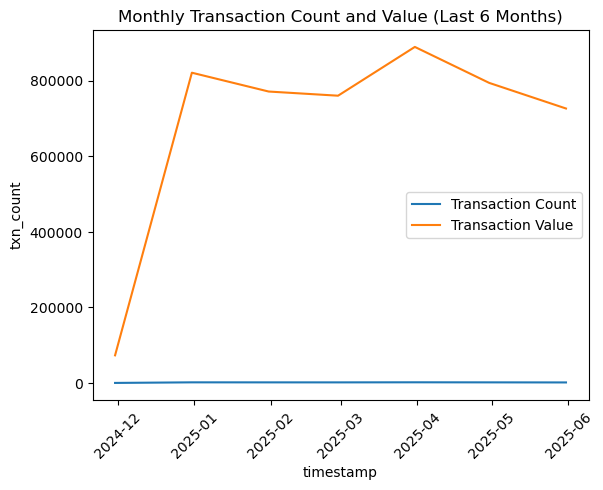

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure timestamp is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Filter for last 6 months
six_months_ago = pd.Timestamp.now() - pd.DateOffset(months=6)
last_6_months = df[df['timestamp'] >= six_months_ago]

# Drop rows with missing txn_id or txn_amount
last_6_months = last_6_months.dropna(subset=['txn_id', 'txn_amount'])

# Group and aggregate
monthly_volume = last_6_months.groupby(pd.Grouper(key='timestamp', freq='M')) \
    .agg(
        txn_count=('txn_id', lambda x: x.nunique()),  # Use nunique for reliable counting
        txn_value=('txn_amount', 'sum')
    ).reset_index()

# Plot
sns.lineplot(data=monthly_volume, x='timestamp', y='txn_count', label='Transaction Count')
sns.lineplot(data=monthly_volume, x='timestamp', y='txn_value', label='Transaction Value')
plt.title("Monthly Transaction Count and Value (Last 6 Months)")
plt.xticks(rotation=45)
plt.show()
=


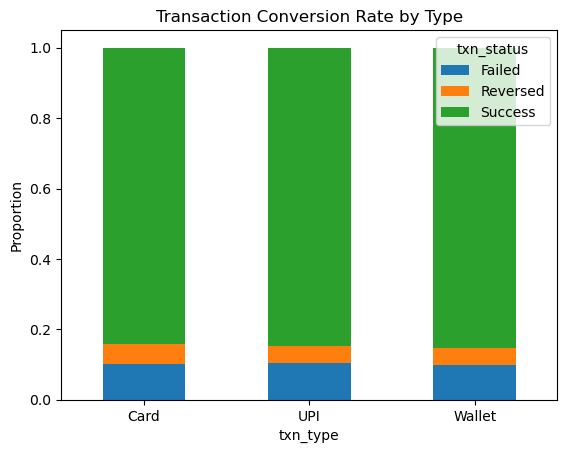

In [11]:
conversion = df.groupby('txn_type')['txn_status'].value_counts(normalize=True).unstack()
conversion.plot(kind='bar', stacked=True)
plt.title('Transaction Conversion Rate by Type')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

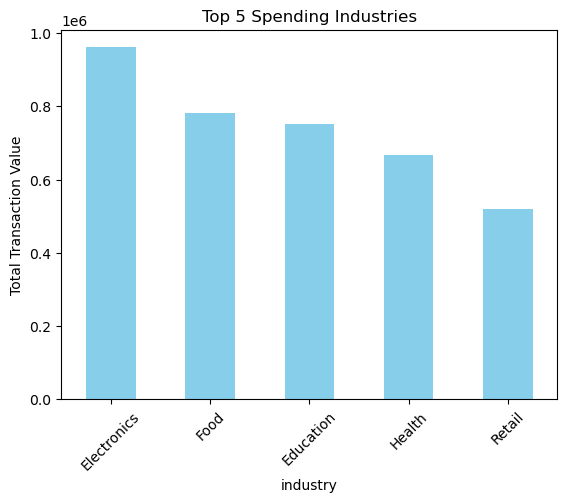

In [12]:
industry_spend = df[df['txn_status'] == 'Success'].groupby('industry')['txn_amount'].sum()
top_5_industries = industry_spend.nlargest(5)

top_5_industries.plot(kind='bar', color='skyblue')
plt.title('Top 5 Spending Industries')
plt.ylabel('Total Transaction Value')
plt.xticks(rotation=45)
plt.show()


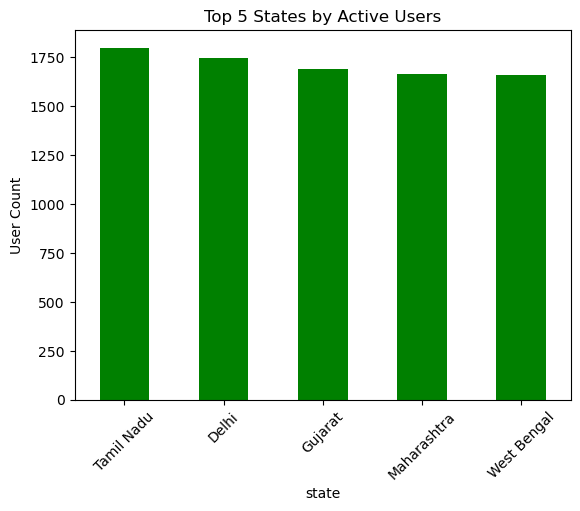

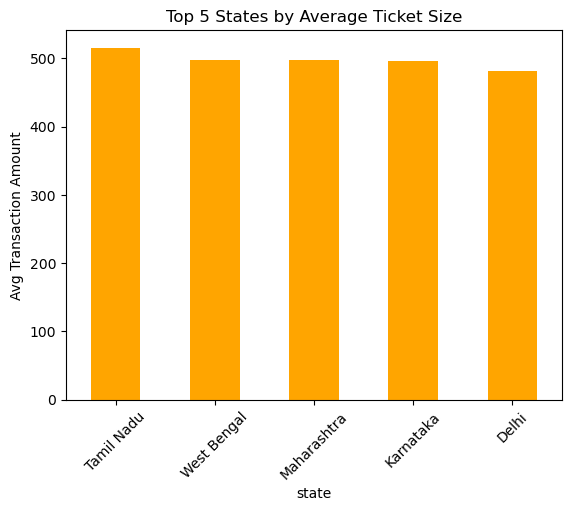

In [13]:
active_users_by_state = df['state'].value_counts().head(5)
avg_ticket_by_state = df[df['txn_status'] == 'Success'].groupby('state')['txn_amount'].mean().nlargest(5)

# Plot active users
active_users_by_state.plot(kind='bar', color='green')
plt.title('Top 5 States by Active Users')
plt.ylabel('User Count')
plt.xticks(rotation=45)
plt.show()

# Plot avg ticket size
avg_ticket_by_state.plot(kind='bar', color='orange')
plt.title('Top 5 States by Average Ticket Size')
plt.ylabel('Avg Transaction Amount')
plt.xticks(rotation=45)
plt.show()


In [24]:
high_value_unverified = df[(df['kyc_status'] != 'Verified') & (df['txn_amount'] > 3000)]
print("Suspicious transactions (high value & unverified KYC):")
print(high_value_unverified[['user_id', 'txn_amount', 'kyc_status', 'timestamp']])


Suspicious transactions (high value & unverified KYC):
     user_id  txn_amount kyc_status           timestamp
5388  U00091     3249.48    Pending 2025-01-10 14:05:34
4435  U00270     3425.48    Pending 2025-02-12 15:00:30
9267  U00383     3116.50    Pending 2024-12-25 15:44:34
8297  U00431     3039.18    Pending 2025-01-28 10:31:09
291   U00758     3020.92    Pending 2025-05-26 05:29:13
1859  U00771     3680.89    Pending 2025-03-16 04:20:07
4050  U00774     3631.84    Pending 2025-03-24 10:56:54
5009  U00869     3416.56    Pending 2025-01-03 06:23:37
2116  U00892     3657.95    Pending 2025-04-14 02:09:58


In [15]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['user_id', 'timestamp'])

from collections import defaultdict
import datetime

user_spike_flags = []

for user_id, group in df.groupby('user_id'):
    times = group['timestamp'].tolist()
    for i in range(len(times) - 5):
        if (times[i + 5] - times[i]) <= pd.Timedelta(minutes=10):
            user_spike_flags.append(user_id)
            break

suspicious_users = df[df['user_id'].isin(user_spike_flags)]
print("Users with transaction spikes:")
print(suspicious_users[['user_id', 'timestamp']].drop_duplicates())


Users with transaction spikes:
Empty DataFrame
Columns: [user_id, timestamp]
Index: []


In [16]:
failed_txns = df[df['txn_status'] == 'Failed']
failed_txns = failed_txns.sort_values(['user_id', 'timestamp'])

flagged_users = []

for user_id, group in failed_txns.groupby('user_id'):
    group_times = group['timestamp'].tolist()
    for i in range(len(group_times) - 2):
        if (group_times[i+2] - group_times[i]) <= pd.Timedelta(minutes=5):
            flagged_users.append(user_id)
            break

suspicious_failed = df[df['user_id'].isin(flagged_users) & (df['txn_status'] == 'Failed')]
print("Users with repeated failed transactions:")
print(suspicious_failed[['user_id', 'timestamp']])


Users with repeated failed transactions:
Empty DataFrame
Columns: [user_id, timestamp]
Index: []


In [17]:
merged_df = transactions.merge(users, on="user_id", how="left")

# Merge the result with merchants
unified_df = merged_df.merge(merchants, on="merchant_id", how="left")

In [18]:
print(unified_df.head())
print(unified_df.columns)
print(unified_df.info())

      txn_id user_id txn_type  txn_amount txn_status            timestamp  \
0  TXN000000  U00503      UPI     1148.58    Success  2025-03-13 14:02:22   
1  TXN000001  U00924      UPI      688.06    Success  2025-05-01 21:19:17   
2  TXN000002  U00470      UPI     1429.94   Reversed  2025-02-14 13:50:47   
3  TXN000003  U00644     Card     1645.30    Success  2025-05-01 01:38:35   
4  TXN000004  U00539      UPI      108.97    Success  2025-01-25 17:15:27   

  merchant_id signup_date kyc_status        state device_type  \
0       M0071  2025-03-23    Pending      Gujarat     Android   
1       M0028  2025-02-20   Verified  West Bengal     Android   
2       M0043  2024-11-16   Verified        Delhi     Android   
3       M0055  2024-08-21   Verified   Tamil Nadu     Android   
4       M0021  2024-06-12   Verified    Karnataka     Android   

                merchant_name     industry  
0                  Wilson Ltd  Electronics  
1                 Jenkins PLC       Retail  
2          

In [19]:
unified_df.to_csv("unified_dataset.csv", index=False)

In [22]:
unified_df.to_csv("Downloads/unified_dataset.csv", index=False)

In [37]:
high_value_unverified = df[(df['kyc_status'] != 'Verified') & (df['txn_amount'] > 3000)].copy()
high_value_unverified['fraud_flag'] = 'High-Value Unverified KYC'

# printing results
print("High-Value Transactions by Unverified KYC:")
print(high_value_unverified[['txn_id', 'user_id', 'txn_amount', 'kyc_status', 'timestamp']])


High-Value Transactions by Unverified KYC:
         txn_id user_id  txn_amount kyc_status           timestamp
291   TXN000291  U00758     3020.92    Pending 2025-05-26 05:29:13
1859  TXN001859  U00771     3680.89    Pending 2025-03-16 04:20:07
2116  TXN002116  U00892     3657.95    Pending 2025-04-14 02:09:58
4050  TXN004050  U00774     3631.84    Pending 2025-03-24 10:56:54
4435  TXN004435  U00270     3425.48    Pending 2025-02-12 15:00:30
5009  TXN005009  U00869     3416.56    Pending 2025-01-03 06:23:37
5388  TXN005388  U00091     3249.48    Pending 2025-01-10 14:05:34
8297  TXN008297  U00431     3039.18    Pending 2025-01-28 10:31:09
9267  TXN009267  U00383     3116.50    Pending 2024-12-25 15:44:34


In [42]:
df_sorted = df.sort_values(['user_id', 'timestamp'])
spike_user_ids = set()

for user, group in df_sorted.groupby('user_id'):
    times = group['timestamp'].tolist()
    for i in range(len(times) - 4):
        if (times[i+4] - times[i]) <= timedelta(minutes=10):
            spike_user_ids.add(user)
            break

spike_user_txns = df[df['user_id'].isin(spike_user_ids)].copy()
spike_user_txns['fraud_flag'] = 'User Transaction Spike'

print("\nUsers with Transaction Spikes:")
print(spike_user_txns[['txn_id', 'user_id', 'timestamp']].head())




Users with Transaction Spikes:
Empty DataFrame
Columns: [txn_id, user_id, timestamp]
Index: []


In [44]:
failed_txns = df[df['txn_status'] == 'Failed'].copy()
failed_txns = failed_txns.sort_values(['user_id', 'timestamp'])

flagged_failed_users = set()

for user, group in failed_txns.groupby('user_id'):
    times = group['timestamp'].tolist()
    for i in range(len(times) - 2):
        if (times[i+2] - times[i]) <= timedelta(minutes=5):
            flagged_failed_users.add(user)
            break

repeated_failed_txns = df[(df['user_id'].isin(flagged_failed_users)) & (df['txn_status'] == 'Failed')].copy()
repeated_failed_txns['fraud_flag'] = 'Repeated Fails in 5 mins'

# printing 
print("\nRepeated Failed Transactions (Same User):")
print(repeated_failed_txns[['txn_id', 'user_id', 'timestamp']].head())



Repeated Failed Transactions (Same User):
Empty DataFrame
Columns: [txn_id, user_id, timestamp]
Index: []


In [39]:
fraud_df = pd.concat([high_value_unverified, spike_user_txns, repeated_failed_txns])
fraud_df = fraud_df.drop_duplicates(subset='txn_id')

# SHOW RESULTS
print("\nCombined Fraud-Flagged Transactions:")
print(fraud_df[['txn_id', 'user_id', 'txn_amount', 'txn_status', 'kyc_status', 'fraud_flag', 'timestamp']].head())



Combined Fraud-Flagged Transactions:
         txn_id user_id  txn_amount txn_status kyc_status  \
291   TXN000291  U00758     3020.92    Success    Pending   
1859  TXN001859  U00771     3680.89     Failed    Pending   
2116  TXN002116  U00892     3657.95    Success    Pending   
4050  TXN004050  U00774     3631.84    Success    Pending   
4435  TXN004435  U00270     3425.48    Success    Pending   

                     fraud_flag           timestamp  
291   High-Value Unverified KYC 2025-05-26 05:29:13  
1859  High-Value Unverified KYC 2025-03-16 04:20:07  
2116  High-Value Unverified KYC 2025-04-14 02:09:58  
4050  High-Value Unverified KYC 2025-03-24 10:56:54  
4435  High-Value Unverified KYC 2025-02-12 15:00:30  
